# SciML M2, TP1: interpolation, incertitude et EDP

On se propose ici d'utiliser les approches introduites dans ce cours pour 
interpoler des solutions obtenues par différence finis et étudier un problème d'incertitude.

### Exercice 1: Interpolation

On considère le problème EDP suivant:

$$
\left\{\begin{array}{l}
-\partial_{xx} u =f, \quad x\in ]0,1[\\
u(0)=u(1)=0\end{array}\right.
$$

avec $f(x)$ un membre de droite donné.

Pour résoudre cette équation on se donne un maillage $M=\left\{x_0,....,x_{n+1}\right\}$ de pas $\Delta x$ et on utilise la méthode 
des différences finis. On note $u_i \approx u(x_i)$. Cela donne le schéma suivant

$$
\frac{-u_{i+1}+2u_i-u_{i-1}}{\Delta x^2} =f(x_i), \quad u_0=u_{n+1}=0
$$

Cela revient a résoudre un système $A u=F$ que l'on détaillera dans le code suivant.

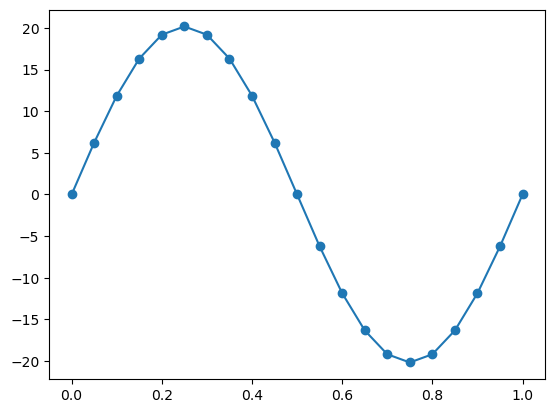

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def solve(N,Mh,vector_f=np.ones(100)):
    dx= 1./N
    A= (2.0/dx)*np.eye(N+1,k=0)-(1.0/dx)*np.eye(N+1,k=-1)-(1.0/dx)*np.eye(N+1,k=1)
    A[0,:]=0.0; A[0,0]=1.0
    A[-1,:]=0.0; A[-1,-1]=1.0
    vector_f[0]=0.0; vector_f[-1]=0.0
    x= np.linalg.solve(A,vector_f)
    return x

N=20
Mh = np.linspace(0,1,N+1)
f=4.0*np.pi**2.0*np.sin(2.0*np.pi*Mh)
x=solve(N,Mh,vector_f=f)

plt.plot(Mh,x)
plt.scatter(Mh,x)


### Exercice 1

- Installez scikit-learn.
- Utilisez les régression polynomiales ou à noyaux (avec plusieurs noyaux) pour interpoler le résultat
sur un maillage de 84 points.
- Validez les résultats obtenus en comparant avec la solution exacte.

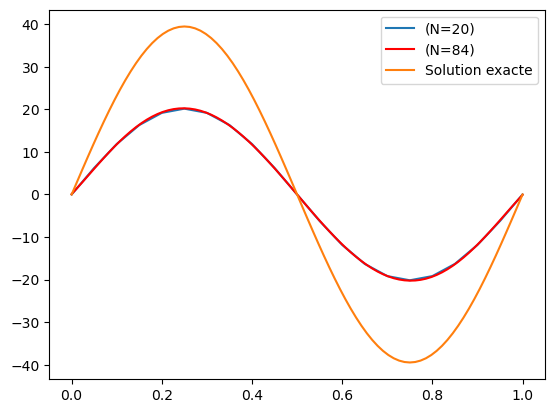

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

Mh2 = np.linspace(0,1,85)

model = Pipeline([('poly', PolynomialFeatures(degree=5)),('linear', LinearRegression(fit_intercept=False))])

model.fit(Mh.reshape(-1, 1), x)

pred = model.predict(Mh2.reshape(-1,1))


exact_solution = 4.0 * np.pi ** 2.0 * np.sin(2.0 * np.pi * Mh2)



plt.plot(Mh, x, label='(N=20)')
plt.plot(Mh2, pred, color='red', label='(N=84)')
plt.plot(Mh2, exact_solution, label='Solution exacte')
plt.legend()
plt.show()

### Exercice 2

Installer pytorch et effectuer la même chose avec un MLP.



Exemple de code perceptron:

'''   
    ## class mlp
    
    class mlp(nn.Module):
        def __init__(self, layer_sizes=list):
            super().__init__()

            self.layer_sizes = layer_sizes
            self.hidden_layers = []

            for i in range(0,len(layer_sizes)-1):
                self.hidden_layers.append(nn.Linear(self.layer_sizes[i], self.layer_sizes[i+1]))

            self.hidden_layers = nn.ModuleList(self.hidden_layers)
            self.activation=nn.Tanh()

        def forward(self, inputs):
            for i in range(0,len(self.layer_sizes)-1):
                inputs = self.activation(self.hidden_layers[i].forward(inputs))
            return inputs
'''

Exemple d'apprentissage

'''
    ## training
    
    from torch.utils.data import TensorDataset, DataLoader
    train_set = TensorDataset(X, Y)
    train_loader = DataLoader(train_set, batch_size=10, shuffle=True)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(epochs):
        total_loss = 0
        num = 0
        for x, y in data:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            print(epoch, total_loss )
'''

In [7]:
import torch
from torch import nn
x = torch.rand(5, 3)
print(x)

class mlp(nn.Module):
    def __init__(self, layer_sizes=list):
        super().__init__()

        self.layer_sizes = layer_sizes
        self.hidden_layers = []

        for i in range(0,len(layer_sizes)-1):
            self.hidden_layers.append(nn.Linear(self.layer_sizes[i], self.layer_sizes[i+1]))
            
        self.hidden_layers = nn.ModuleList(self.hidden_layers)
        self.activation=nn.Tanh()

    def forward(self, inputs):
        for i in range(0,len(self.layer_sizes)-1):
           inputs = self.activation(self.hidden_layers[i].forward(inputs))
        return inputs


tensor([[0.0548, 0.7705, 0.4727],
        [0.9202, 0.8390, 0.5346],
        [0.5062, 0.4985, 0.1102],
        [0.6598, 0.1749, 0.7423],
        [0.7424, 0.5267, 0.7565]])


In [9]:
from torch.utils.data import TensorDataset, DataLoader
train_set = TensorDataset(X, Y)
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
for epoch in range(epochs):
    total_loss = 0
    num = 0
    for x, y in data:
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        print(epoch, total_loss )

NameError: name 'X' is not defined

### Exercice 3

On se propose d'étudier la propagation d'incertitude.

On suppose qu'on ne connait pas exactement f mais qu'on connait deux choses:
- des valeurs ponctuelles de $f$
- la régularité de $f$

On voudrait propager l'incertitude qu'on a sur $f$ (qui suit une loi $P$) et connaitre celle qu'on a sur $u$

Pour cela, on suppose qu'on peut échantillonner des fonctions $f$ aux points de mesures.
On pose $\mathbf{f}=(f^1,...,f^m)$ un membre de droite qui évalue une fonction $f$ aux $m$ points de mesures.

On note $\mathbf{f}_i$ un échantillon aléatoire de $P$.
Si on résout avec notre schéma aux différence finis le problème associé à $\mathbf{f}_i$ on
obtient $\mathbf{u}_i$.

A l'aide d'estimateur empirique on peut construire la moyenne et la variance de la loi sur les solutions $u$
avec

$$
E[u]=\frac{1}{n}\sum_{i=1}^n\mathbf{u}_i, \quad Var(u)=\frac{1}{n}\sum_{i=1}^n(\mathbf{u}_i-E[u])^2
$$

On veut donc tracer l'incertitude sur $u$. Pour cela on va tracer
$E[u]$ et l'ecart type $\sigma=\sqrt{Var(U)}$ avec

'''
    ## code pour afficher moyenne et ecart type
    
    plt.plot(X, mean_prediction, label="Mean prediction")
    plt.fill_between(
        X.ravel(),
        mean_prediction - 1.96 * std_prediction,
        mean_prediction + 1.96 * std_prediction,
        alpha=0.5,
        label=r"95% confidence interval",
    )
'''

Maintenant il reste a construire la loi de $f$ nommé $P$

Pour cela on va choisir un processus Gaussien qui va échantillonner des fonctions de régularité donnée.
Puis on va le contraindre par des données.

Pour cela:
- on choisira $m$ points $(x_1,sin(x_1)+\epsilon_1,...,x_m,sin(x_m)+\epsilon_m)$,
- on "fitera" le processus Gaussien,
- on échantillonnera $n$ sources,
- on calcul les $n$ solutions,
- on calcul la loi de $u$,
- on affiche le résultat.